In [1]:
from models.MNIST_Models import *
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import utils
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.defences.trainer import AdversarialTrainer
from copy import deepcopy
import os

In [2]:
# Load the data
BATCH_SIZE = 256
EPS = 0.2

torch.manual_seed(42)
np.random.seed(42)
generator = torch.Generator().manual_seed(42)

# Define the transformation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000], generator=generator)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_train, y_train = utils.loader_to_numpy(train_loader)
X_val, y_val = utils.loader_to_numpy(val_loader)
X_test, y_test = utils.loader_to_numpy(test_loader)

In [3]:
def harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, attack_obj, plot_title):
    
    if isinstance(attack_obj, FastGradientMethod):
        hardened_prefix = 'FGSM'
    elif isinstance(attack_obj, BasicIterativeMethod):
        hardened_prefix = 'BIM'
    elif isinstance(attack_obj, ProjectedGradientDescent):
        hardened_prefix = 'PGD'
    elif isinstance(attack_obj, DeepFool):
        hardened_prefix = 'DF'
    else:
        raise Exception("Enter a valid attack object")
        
    save_path = os.path.join('models', 'hardened_state', f'{hardened_prefix}_{model_name}.pth')
                             
    try:
        hardened_model = torch.load(save_path)
        hardened_classifier = PyTorchClassifier(
            model=hardened_model,
            loss=torch.nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
            input_shape=(1, 28, 28),
            nb_classes=10,
            preprocessing=(0.1307, 0.3081),
            device_type='gpu'
        )
        if isinstance(attack_obj, DeepFool):
            attack = attack_obj(hardened_classifier, batch_size=BATCH_SIZE)
        else:
            attack = attack_obj(hardened_classifier, batch_size=BATCH_SIZE, eps=EPS)
    except:
        hardened_model = deepcopy(clean_model)
        hardened_classifier = PyTorchClassifier(
            model=hardened_model,
            loss=torch.nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
            input_shape=(1, 28, 28),
            nb_classes=10,
            preprocessing=(0.1307, 0.3081),
            device_type='gpu'
        )
        if isinstance(attack_obj, DeepFool):
            attack = attack_obj(hardened_classifier, batch_size=BATCH_SIZE)
        else:
            attack = attack_obj(hardened_classifier, batch_size=BATCH_SIZE, eps=EPS)
        adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
        adv_trainer.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epochs=10)
        torch.save(adv_trainer.classifier.model, save_path)
        hardened_classifier = adv_trainer.classifier
    
    
    eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=BATCH_SIZE, title=plot_title)
    
    print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
    print(f'Hardened model accuracy on {str(attack_obj)} adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [4]:
def run_adversarial_process(clean_model, BATCH_SIZE, EPS, model_name, plot_title):
    clean_classifier = PyTorchClassifier(
    model=clean_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(clean_model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

    # Get the clean accuracy
    clean_acc = np.sum(np.argmax(clean_classifier.predict(X_test), axis=1) == y_test) / len(y_test)
    print(f'Clean accuracy: {clean_acc}')
    
    # Try FGSM
    attack = FastGradientMethod(clean_classifier, batch_size=BATCH_SIZE, eps=EPS)
    print('Accuracy on FGSM adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)
    
    # Try BIM
    attack = BasicIterativeMethod(clean_classifier, batch_size=BATCH_SIZE, eps=EPS)
    attack.generate()
    print('Accuracy on BIM adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)
    
    # Try PGD
    attack = ProjectedGradientDescent(clean_classifier, batch_size=BATCH_SIZE, eps=EPS)
    print('Accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)
    
    # Try deepfool
    attack = DeepFool(clean_classifier, batch_size=BATCH_SIZE)
    print('Accuracy on DeepFool adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)
    
    # harden with BIM
    harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, BasicIterativeMethod, plot_title + ' Hardened with BIM')
    
    # harden with PGD
    harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, ProjectedGradientDescent, plot_title + ' Hardened with PGD')
    
    # harden with FGSM
    harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, FastGradientMethod, plot_title + ' Hardened with FGSM')
    
    # harden with DeepFool
    harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, DeepFool, plot_title + ' Hardened with DeepFool')

Clean accuracy: 0.9845
Accuracy on FGSM adversarial test data:  0.5251


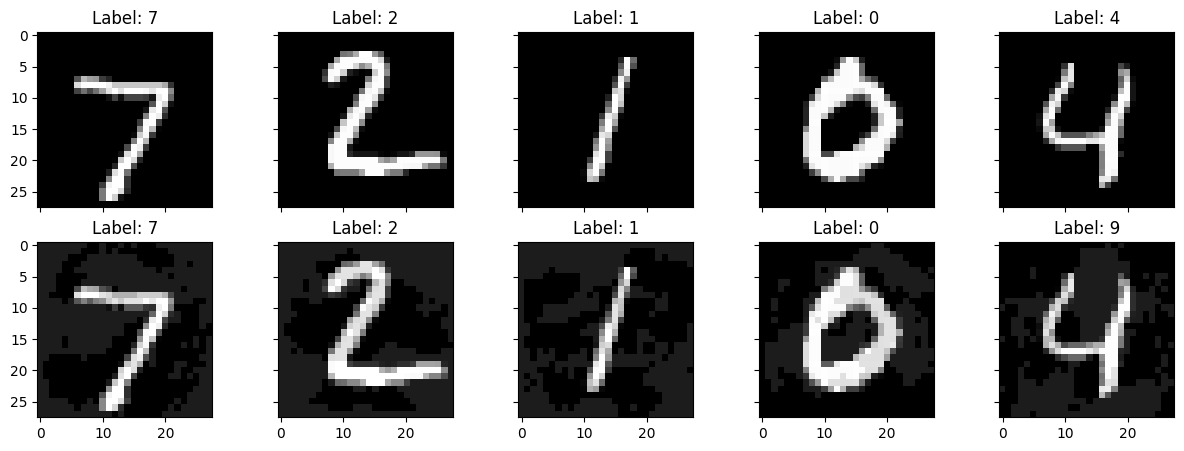

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on BIM adversarial test data:  0.1897


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

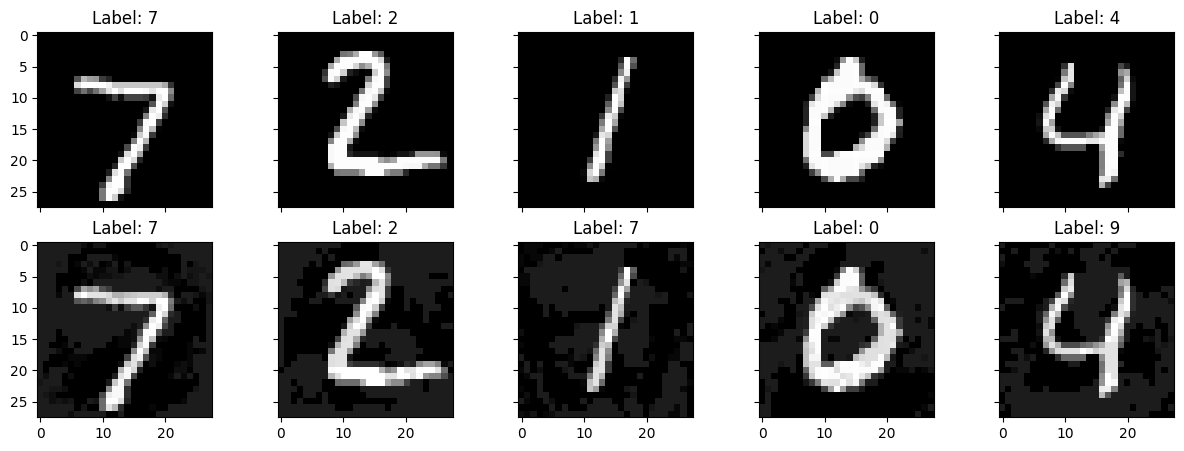

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on PGD adversarial test data:  0.1897


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

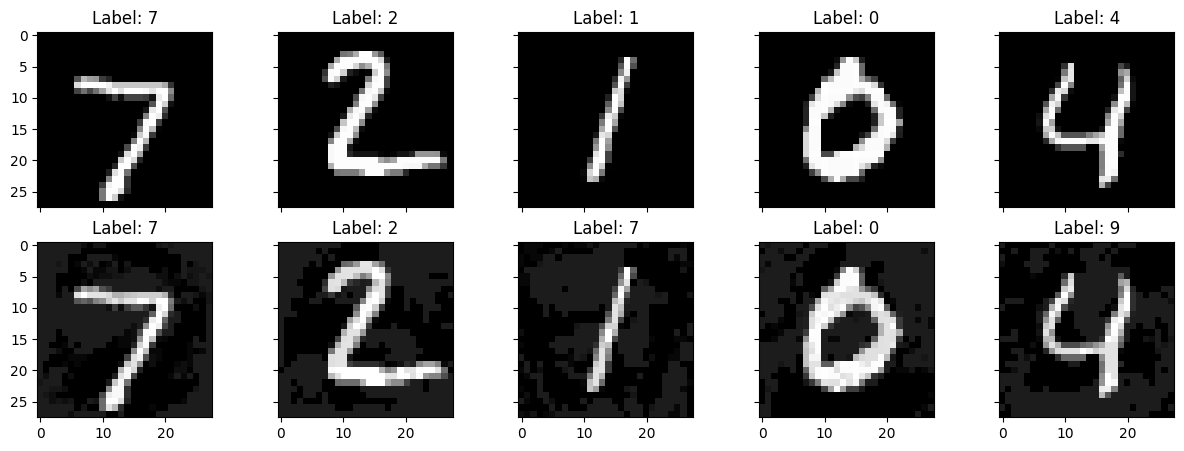

DeepFool:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on DeepFool adversarial test data:  0.0124


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

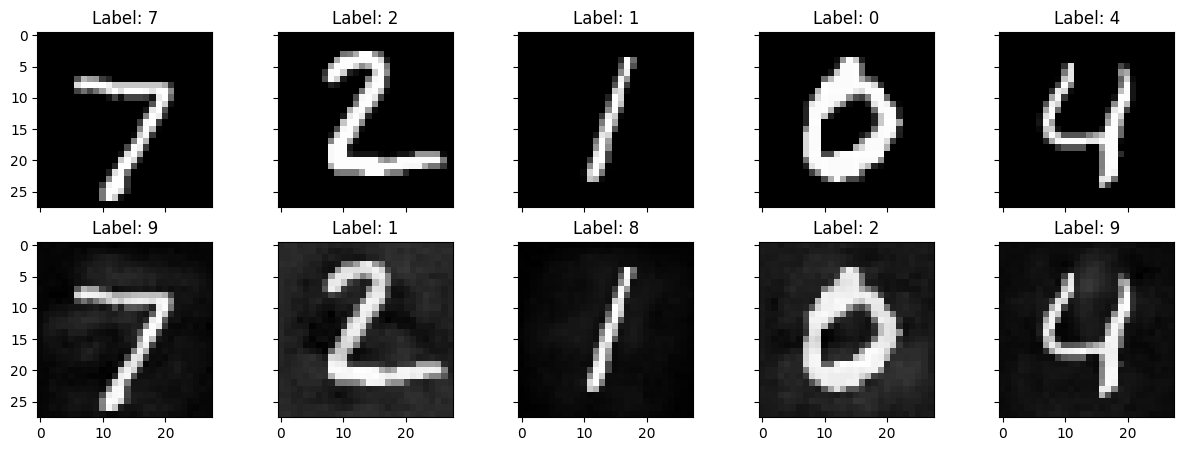

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
# load the FC model
clean_model = MNIST_FC_500_100_10()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_FC_500_100_10.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_FC_500_100_10', 'MNIST_FC_500_100_10 Adversarial Accuracy')

In [ ]:
# load the VGG model
clean_model = MNIST_VGG()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_VGG.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_VGG', 'MNIST_VGG Adversarial Accuracy')

In [ ]:
# load the LeNet model
clean_model = MNIST_LeNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_LeNet.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_LeNet', 'MNIST_LeNet Adversarial Accuracy')

In [ ]:
# load the GoogLeNet model
clean_model = MNIST_GoogLeNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_GoogLeNet.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_GoogLeNet', 'MNIST_GoogLeNet Adversarial Accuracy')

In [ ]:
# load the ResNet model
clean_model = MNIST_ResNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_ResNet.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_ResNet', 'MNIST_ResNet Adversarial Accuracy')